In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import matplotlib.pyplot as plt

In [109]:
# map of all actions 
ACTION_MAP = {
    'baseball_pitch': 0, 'baseball_swing': 1, 'bench_press': 2, 'bowl': 3,
    'clean_and_jerk': 4, 'golf_swing': 5, 'jump_rope': 6, 'jumping_jacks': 7,
    'pullup': 8, 'pushup': 9, 'situp': 10, 'squat': 11,
    'strum_guitar': 12, 'tennis_forehand': 13, 'tennis_serve': 14
}

class PennActionDataset(Dataset):
    def __init__(self, frames_dir, labels_dir, transform=None):
        self.frames_dir = frames_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.frame_paths = []
        self.action_labels = []
        
        image_sequence_folders = sorted(os.listdir(frames_dir))
        
        for seq_folder in image_sequence_folders:
            if seq_folder != ".DS_Store":
                seq_frames_path = os.path.join(frames_dir, seq_folder)
                
                frames = sorted(os.listdir(seq_frames_path))
                if frames[0] == ".DS_Store":
                    frames.remove(".DS_Store")

                #sampled_frames = frames[::40]
                middle = int((len(frames) - 1)/2)
                sample_frame = frames[middle]
                '''
                for frame in sampled_frames:
                    frame_path = os.path.join(seq_frames_path, frame)
                              
                    self.frame_paths.append(frame_path)
                
                    label_path = os.path.join(labels_dir, seq_folder + '.mat')
                    annotation = loadmat(label_path)
                    action_label = annotation['action'][0]
                    self.action_labels.append(ACTION_MAP[action_label])
                '''
                frame_path = os.path.join(seq_frames_path, sample_frame)
                              
                self.frame_paths.append(frame_path)
            
                label_path = os.path.join(labels_dir, seq_folder + '.mat')
                annotation = loadmat(label_path)
                action_label = annotation['action'][0]
                self.action_labels.append(ACTION_MAP[action_label])
    
    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(self.action_labels[idx])
        return img, label

    def __len__(self):
        return len(self.frame_paths)


In [110]:
# Convert to Tensor 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalize
])

# Load dataset
frames_dir = '/Users/jnehra/Desktop/ML/Penn_Action/frames'
labels_dir = '/Users/jnehra/Desktop/ML/Penn_Action/labels'

dataset = PennActionDataset(frames_dir, labels_dir, transform=transform)

In [111]:
# CNN model 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 15) # 15 outputs 
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

In [112]:
# Split dataset to train and test 
#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#print(len(train_dataset))
labels = [dataset.action_labels[i] for i in range(len(dataset))]

# Stratified split
train_indices, test_indices = train_test_split(
    range(len(dataset)), 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

# Create subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN().to(device)

Using device: cpu


In [113]:
# Cross-entropy loss as the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [114]:
train_losses = []
test_accuracies = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # training 
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # backpropagation 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  # weight update 
    
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # testing 
    # Set model to eval mode 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    test_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {100 * correct/total:.2f}%, "
          f"Validation Loss: {val_loss/len(test_loader):.4f}, Validation Accuracy: {100 * val_correct/val_total:.2f}%")


Epoch 1/20: Train Loss: 2.5718, Train Accuracy: 14.57%, Validation Loss: 2.4322, Validation Accuracy: 18.67%
Epoch 2/20: Train Loss: 2.3033, Train Accuracy: 26.13%, Validation Loss: 2.2753, Validation Accuracy: 24.46%
Epoch 3/20: Train Loss: 2.0396, Train Accuracy: 34.52%, Validation Loss: 2.2702, Validation Accuracy: 24.25%
Epoch 4/20: Train Loss: 1.8202, Train Accuracy: 42.31%, Validation Loss: 2.0844, Validation Accuracy: 30.47%
Epoch 5/20: Train Loss: 1.5373, Train Accuracy: 53.12%, Validation Loss: 2.1892, Validation Accuracy: 30.26%
Epoch 6/20: Train Loss: 1.4022, Train Accuracy: 56.94%, Validation Loss: 2.1766, Validation Accuracy: 31.97%
Epoch 7/20: Train Loss: 1.1563, Train Accuracy: 65.48%, Validation Loss: 1.9116, Validation Accuracy: 36.27%
Epoch 8/20: Train Loss: 0.9425, Train Accuracy: 73.49%, Validation Loss: 1.9390, Validation Accuracy: 40.13%
Epoch 9/20: Train Loss: 0.6692, Train Accuracy: 81.08%, Validation Loss: 2.0860, Validation Accuracy: 41.85%
Epoch 10/20: Train 

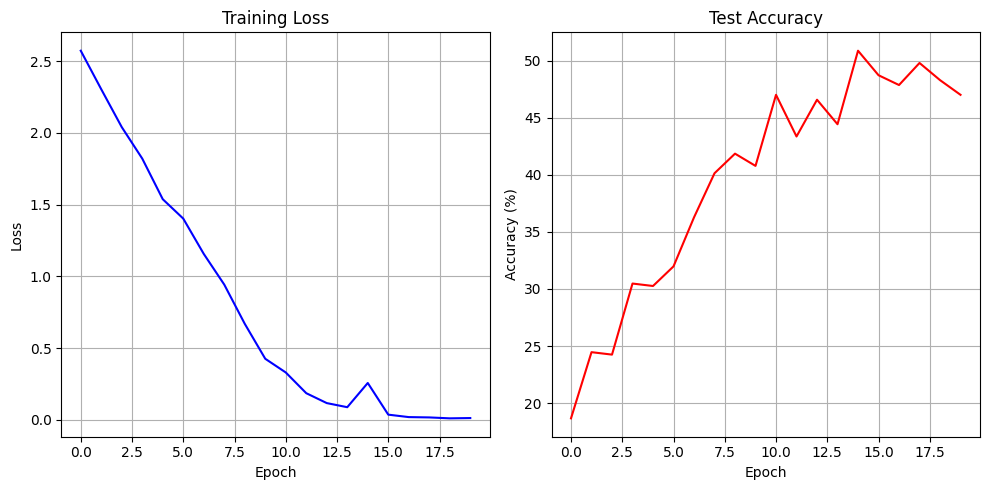

In [115]:
# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()